In [64]:
import time
import cv2
import os
from random import shuffle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

DIR = r'data\pet'
IMG_SIZE = 50

# Load

We have to transform the images into arrays and load them into a DataFrame.  
Then, we gotta label the data

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return 0
    else: return 1

In [3]:
def create_data():
    data = []
    for img in tqdm(os.listdir(DIR)):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        data.append((np.array(img), label))
    shuffle(data)
    return data

In [4]:
start = time.time()
data = create_data()
end = time.time()
print('runtime:',end - start, 'seconds')

100%|██████████| 25000/25000 [00:20<00:00, 1217.44it/s]

runtime: 21.20583987236023 seconds


In [5]:
df = pd.DataFrame(data=np.array([x[0] for x in data]).reshape(25000, IMG_SIZE*IMG_SIZE))
df['label'] = [x[1] for x in data]

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,label
0,95,93,87,95,98,88,103,111,131,125,...,160,166,177,176,151,136,127,117,102,0
1,114,115,115,115,115,115,115,115,115,115,...,110,65,67,44,51,44,51,52,55,0
2,250,242,248,247,215,233,238,242,247,246,...,69,29,30,58,65,59,52,43,44,1
3,23,26,45,45,9,7,6,10,6,26,...,109,102,109,142,132,120,156,150,101,0
4,100,104,104,104,104,104,108,108,108,108,...,128,132,45,40,80,164,200,188,196,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,255,255,255,255,255,255,255,255,255,255,...,242,243,239,239,253,253,252,244,200,0
24996,168,185,197,200,199,200,200,199,204,204,...,113,98,86,76,70,64,55,69,90,0
24997,75,39,64,69,69,69,69,69,69,69,...,118,99,62,50,5,5,5,5,5,1
24998,168,168,166,161,159,147,125,108,78,47,...,82,74,94,45,39,42,46,44,41,1


# Verify

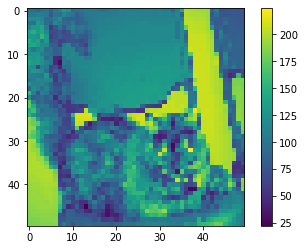

In [7]:
plt.figure()
plt.imshow(data[0][0])
plt.colorbar()
plt.grid(False)
plt.show()

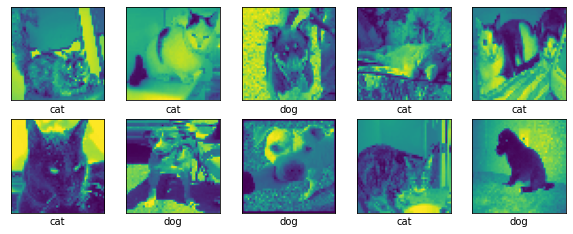

In [9]:
def what_class(x):
    if x==1: return 'dog'
    else: return 'cat'
    
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i][0])
    plt.xlabel(what_class(df['label'][i]))
plt.show()

# Models

In [10]:
x=df.drop('label',axis=1)
y=df.label
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)

## 'Weak' learners:

### KNN

In [11]:
# KNN
start = time.time()
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 0.012956857681274414 seconds


### Decision Tree

In [12]:
# Decision Tree
start = time.time()
dct = DecisionTreeClassifier(random_state=0)
dct.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 35.40438652038574 seconds


### Logistic Regression

In [13]:
# Logistic Regression
start = time.time()
logreg = LogisticRegression(solver='saga',max_iter=200, n_jobs=-1)
logreg.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 71.15404963493347 seconds


## Ensemble

### Random Forest

In [14]:
# Random Forest
start = time.time()
rnd = RandomForestClassifier(random_state=42, n_estimators=150, n_jobs=-1)
rnd.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 16.5887234210968 seconds


### Hard Voting

In [15]:
# Voting
start = time.time()
hard_voting = VotingClassifier(voting='hard', estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
hard_voting.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 85.62774920463562 seconds


### Soft Voting

In [16]:
# Voting
start = time.time()
soft_voting = VotingClassifier(voting='soft', estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
soft_voting.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 83.54130244255066 seconds


### Stacking

In [17]:
# Stacking 
start = time.time()
stacking = StackingClassifier(estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
stacking.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 267.34693574905396 seconds


## Boosting

### Adaboost

In [18]:
# Adaboost
start = time.time()
adaboost = AdaBoostClassifier(base_estimator=rnd)
adaboost.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 16.957621812820435 seconds


### Gradient boost

In [19]:
# Gradientboost
start = time.time()
gradient = GradientBoostingClassifier()
gradient.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 656.4936048984528 seconds


### XGBoost

In [20]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', n_jobs=-1)
xgboost.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 37.35402297973633 seconds


## Clustering

### K-means

In [104]:
start = time.time()
k = 2
kmeans = KMeans(n_clusters=k, init='random', n_init=30)
kmeans.fit(x_train, y_train)
y_pred = kmeans.predict(x_test)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 10.343413829803467 seconds


### Scores

In [21]:
start = time.time()
for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, stacking, adaboost, gradient, xgboost]:
    print(model.__class__.__name__,"    ", model.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

KNeighborsClassifier      0.5526
DecisionTreeClassifier      0.547
LogisticRegression      0.547
RandomForestClassifier      0.6398
VotingClassifier      0.5866
VotingClassifier      0.5786
StackingClassifier      0.6406
AdaBoostClassifier      0.6474
GradientBoostingClassifier      0.6406
XGBClassifier      0.6568
runtime: 340.86191749572754 seconds


In [111]:
print('Kmeans')
print(classification_report(y_test,y_pred))

Kmeans
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      2529
           1       0.53      0.53      0.53      2471

    accuracy                           0.53      5000
   macro avg       0.53      0.53      0.53      5000
weighted avg       0.53      0.53      0.53      5000



XGBoost is the best classifier. lets fine-tune it to get the best accuracy.  
In order to save time, we'll do Grid Search "manually":

In [24]:
#XGBoost
start = time.time()
m = 0
k = 0
maximum = 0
for i in [0.1,0.3,0.5]:
    for j in [50,100,150]:
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j, n_jobs=-1)
        xgboost.fit(x_train, y_train)
        score = xgboost.score(x_test,y_test)
        print('learning_rate:',i,', n_estimators:',j,'-',score)
        if score>maximum:
            m = i
            k = j
            maximum = score
end = time.time()
print('runtime:',end - start, 'seconds')

learning_rate: 0.1 , n_estimators: 50 - 0.6414
learning_rate: 0.1 , n_estimators: 100 - 0.661
learning_rate: 0.1 , n_estimators: 150 - 0.6624
learning_rate: 0.3 , n_estimators: 50 - 0.6462
learning_rate: 0.3 , n_estimators: 100 - 0.6568
learning_rate: 0.3 , n_estimators: 150 - 0.6634
learning_rate: 0.5 , n_estimators: 50 - 0.6312
learning_rate: 0.5 , n_estimators: 100 - 0.6486
learning_rate: 0.5 , n_estimators: 150 - 0.6546
runtime: 338.92502450942993 seconds


### Best Model:

In [38]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=m, n_estimators=k, n_jobs=-1)
xgboost.fit(x_train, y_train)
end = time.time()
print('learning_rate =',m,'n_estimators =',k)
print('runtime:',end - start, 'seconds')

learning_rate= 0.3 n_estimators= 150
runtime: 59.93297743797302 seconds


### Dimensionality reduction using PCA

In [29]:
start = time.time()
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 9.562169075012207 seconds


Text(0, 0.5, 'variance preserved')

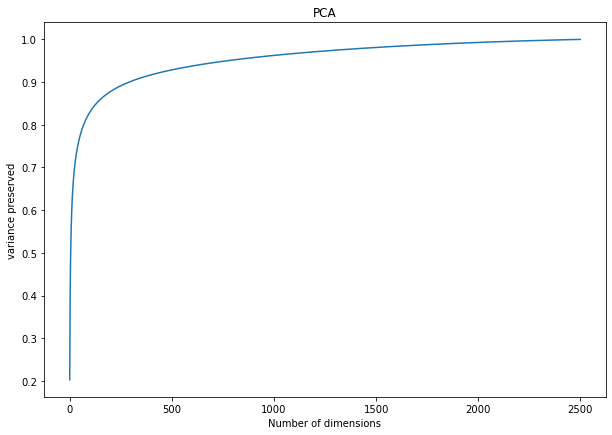

In [30]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
plt.plot(cumsum)
plt.title('PCA')
plt.xlabel('Number of dimensions')
plt.ylabel('variance preserved')

We will preserve 80% of the variance.

In [56]:
print('number of dimensions:',np.argmax(cumsum >= 0.80))

number of dimensions: 68


In [40]:
pca = PCA(n_components=0.80)
x1_reduced = pca.fit_transform(x_train)
x2_reduced = pca.transform(x_test)

We'll redo "manual" Grid Search for our xgboost classifier since it provides the best accuracy:

In [41]:
#XGBoost
start = time.time()
m = 0
k = 0
maximum = 0
for i in [0.1,0.3,0.5]:
    for j in [50,100,150]:
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j, n_jobs=-1)
        xgboost.fit(x1_reduced, y_train)
        score = xgboost.score(x2_reduced,y_test)
        print('learning_rate:',i,', n_estimators:',j,'-',score)
        if score>maximum:
            m = i
            k = j
            maximum = score
end = time.time()
print('runtime:',end - start, 'seconds')

learning_rate: 0.1 , n_estimators: 50 - 0.6308
learning_rate: 0.1 , n_estimators: 100 - 0.6368
learning_rate: 0.1 , n_estimators: 150 - 0.6354
learning_rate: 0.3 , n_estimators: 50 - 0.622
learning_rate: 0.3 , n_estimators: 100 - 0.6328
learning_rate: 0.3 , n_estimators: 150 - 0.6334
learning_rate: 0.5 , n_estimators: 50 - 0.6244
learning_rate: 0.5 , n_estimators: 100 - 0.6256
learning_rate: 0.5 , n_estimators: 150 - 0.623
runtime: 42.769649028778076 seconds


### Best Model
After PCA

In [42]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=m, n_estimators=k, n_jobs=-1)
xgboost.fit(x1_reduced, y_train)
end = time.time()
print('learning_rate =',m,'n_estimators =',k)
print('runtime:',end - start, 'seconds')

learning_rate = 0.1 n_estimators = 100
runtime: 4.732237339019775 seconds


In [57]:
xgboost.score(x2_reduced, y_test)

0.6368

### We may have lost about 2% of accuracy, BUT we gave up on 2,432 features! Seems like a great trade.